## ESI at AMO
# Figure: diffraction patterns

In [12]:
%pylab inline
import pickle, os
import condor, spimage, h5py
from matplotlib.colors import LogNorm

Populating the interactive namespace from numpy and matplotlib


/Users/max.hantke/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Location of input files

In [13]:
data_path = './xfel_data/'
#data_path = '/Users/benedikt/data/LCLS/amol3416/phasing/'
filename_tbsv_singles = data_path + 'tbsv_phased_single_%d.h5'
filename_tbsv_doubles = data_path + 'tbsv_phased_double_%d.h5'
filename_cbx_singles = data_path + 'cbx_phased_single_%d.h5'

## 1) TBSV

### Read data

In [14]:
# TBSV
tbsv_singles = [0,1]
tbsv_doubles = [0,1]

images_tbsv = []
phased_tbsv = []
mask_tbsv = []
for i in tbsv_singles:
    with h5py.File(filename_tbsv_singles %i, 'r') as f:
        images_tbsv.append(f['data'][:])
        mask_tbsv.append(~f['mask'][:])
        phased_tbsv.append(f['super_image'][:])
for i in tbsv_doubles:
    with h5py.File(filename_tbsv_doubles %i, 'r') as f:
        images_tbsv.append(f['data'][:])
        mask_tbsv.append(~f['mask'][:])
        phased_tbsv.append(f['super_image'][:])
images_tbsv = np.array(images_tbsv)
phased_tbsv = np.array(phased_tbsv)
mask_tbsv = np.array(mask_tbsv)
Nx = mask_tbsv.shape[2]
Ny = mask_tbsv.shape[1]

### Simulation

In [16]:
ds_tbsv = 8
edge_length_tbsv = 910
wl = condor.source.Photon(energy_eV=800.).get_wavelength()
print(wl)
S = condor.Source(wavelength=wl, focus_diameter=3.E-6, pulse_energy=0.2*1E-3)
D_distance = 0.25
D = condor.Detector(distance=D_distance, pixel_size=75E-6, nx=Nx, ny=Ny)

# Single
P1 = condor.ParticleSphere(diameter=30E-9, material_type="cell")#, rotation_formalism='random')
E1 = condor.Experiment(S, {"particle_sphere": P1}, D)
res1 = E1.propagate()
in1 = res1['entry_1']['data_1']['data']
rs1 = spimage.crop(abs(fftshift(ifftn(fftshift(res1['entry_1']['data_1']['data_fourier'])))), 30)
#imshow(in1)

# Double
P2 = condor.ParticleSphere(diameter=30E-9, material_type="cell", position=[0.,0.,0.], position_variation_n=[2,1,1], position_spread=[28E-9,0.,0.], position_variation="range", number=2)
E2 = condor.Experiment(S, {"particle_sphere": P2}, D)
res2 = E2.propagate()
in2 = res2['entry_1']['data_1']['data']
rs2 = spimage.crop(abs(fftshift(ifftn(fftshift(res2['entry_1']['data_1']['data_fourier'])))), 30)
#imshow(in2)

sims_tbsv = [array(poisson(in1), dtype='f'), array(poisson(in2), dtype='f')]
rssims_tbsv = [rs1, rs2]

1.54980246746e-09


### Reconstructions

In [6]:
cx,cy = (phased_tbsv[0].shape[1]-30)//2, (phased_tbsv[0].shape[0]-30)//2
rec11 = np.abs(phased_tbsv[0][cy:-cy, cx:-cx])
rec12 = np.abs(phased_tbsv[1][cy:-cy, cx:-cx])
rec21 = np.abs(phased_tbsv[2][cy:-cy, cx:-cx])
rec22 = np.abs(phased_tbsv[3][cy:-cy, cx:-cx])

rsrecs_tbsv = [rec11, rec12, rec21, rec22]

## 2) Carboxysomes

### Read data

In [7]:
# CBX
cbx_singles = [0,1,8,4,7]

images_cbx =[]
mask_cbx = []
phased_cbx = []
for i in cbx_singles:
    with h5py.File(filename_cbx_singles %i, 'r') as f:
        images_cbx.append(f['data'][:])
        mask_cbx.append(~f['mask'][:])
        phased_cbx.append(f['super_image'][:])
images_cbx = np.array(images_cbx)
phased_cbx = np.array(phased_cbx)
mask_cbx = np.array(mask_cbx)
Nx = mask_cbx.shape[2]
Ny = mask_cbx.shape[1]

### Simulation

In [8]:
ds_cbx = 8
edge_length_cbx = 900
wl = condor.source.Photon(energy_eV=800.).get_wavelength()
S = condor.Source(wavelength=wl, focus_diameter=3.E-6, pulse_energy=0.05*1E-3)
D = condor.Detector(distance=0.370, pixel_size=75E-6, nx=Nx, ny=Ny)

# Single
PI = condor.ParticleMap(diameter=100E-9, material_type="cell", geometry="icosahedron", rotation_values=[1.,0.,0.,0.3], rotation_formalism='quaternion')
EI = condor.Experiment(S, {"particle_map": PI}, D)
resI = EI.propagate()
inI = resI['entry_1']['data_1']['data']
rsI = spimage.crop(abs(fftshift(ifftn(fftshift(resI['entry_1']['data_1']['data_fourier'])))), 30)

sims_cbx = [array(poisson(inI), dtype='f'), images_cbx[-1]]

In [9]:
cx,cy = (phased_cbx.shape[2]-30)//2, (phased_cbx.shape[1]-30)//2
rec11 = np.abs(phased_cbx[0][cy:-cy, cx:-cx])
rec12 = np.abs(phased_cbx[1][cy:-cy, cx:-cx])
rec21 = np.abs(phased_cbx[2][cy:-cy, cx:-cx])
rec22 = np.abs(phased_cbx[3][cy:-cy, cx:-cx])
rec23 = np.abs(phased_cbx[4][cy:-cy, cx:-cx])

rsrecs_cbx = [rec11, rec12, rec21, rec22]
rssims_cbx = [rsI,rec23]

### Plot Carboxysomes and TBSV together

/Users/max.hantke/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log10
/Users/max.hantke/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log10


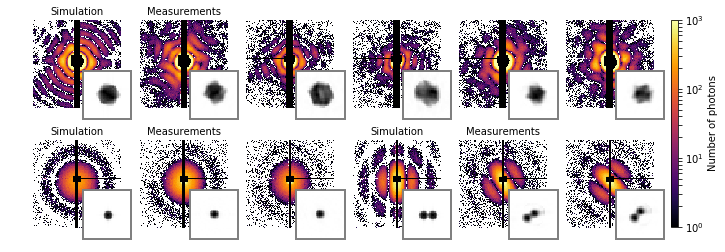

In [11]:
from matplotlib.font_manager import FontProperties
font_b = FontProperties().copy()
font_b.set_weight('bold')
font_n = FontProperties().copy()

sf = 0.5
fw = sf*20
fh = sf*7
fr = fw/fh
fig= figure(figsize=(fw,fh))
Nax = 6
w = 1/float(2.2+Nax)
h = 0.9/2.
x0 = linspace(0.01, 0.75, Nax)
y0 = 0.05/2.

axs2 = [fig.add_axes([x0i,y0+h+y0,w,h]) for x0i in x0]
axs2_is = [fig.add_axes([x0i+w*0.57,2*y0+h-0.02,w*0.55,h*0.55]) for x0i in x0]
axs1 = [fig.add_axes([x0i,y0,w,h]) for x0i in x0]
axs1_is = [fig.add_axes([x0i+w*0.57,y0-0.02,w*0.55,h*0.55]) for x0i in x0]
axc = fig.add_axes([0.75+w*1.2, 0.08, 0.01, 0.9-0.08])

cmap = 'inferno'
for axs, axs_is, images, mask, sims, ds, edge_length,label in zip([axs1, axs2], [axs1_is, axs2_is],
                                                               [images_tbsv, images_cbx], [mask_tbsv, mask_cbx], [sims_tbsv, sims_cbx],
                                                               [ds_tbsv, ds_cbx], [edge_length_tbsv, edge_length_cbx],[("b","c"),("a","")]):
    
    for ax,_img, msk in zip(axs, [sims[0]] + [images[0]] + [images[1]] + [sims[1]] + [images[2]] + [images[3]],
                      [mask[0]] + [mask[0]] + [mask[1]] + [mask[1]] + [mask[2]] + [mask[3]]):
        img = _img.copy()
        img[img<0.75] = 0
        if edge_length is not None:
            img = spimage.crop(img, cropLength=edge_length, center=(512+25, 512))
            msk = spimage.crop(msk, cropLength=edge_length, center=(512+25, 512))
        img, msk = spimage.binImage(img, ds, msk=msk==0, output_binned_mask=True)
        im = ax.imshow(img, norm=LogNorm(1, 1000), cmap=cmap, interpolation="nearest")
        ax.imshow(log10((1-msk)*10), cmap="binary_r")
        ax.set_axis_off()
    #axs[0].annotate(label[0], (0.,1.15), xycoords="axes fraction",ha="right", va="top", fontproperties=font_b)
    axs[0].annotate("Simulation", (0.5,1.15), xycoords="axes fraction",ha="center", va="top", fontproperties=font_n)
    if label[1]:
        axs[3].annotate("Simulation", (0.5,1.15), xycoords="axes fraction",ha="center", va="top", fontproperties=font_n)
    if label[0] in ["b","c"]:
        axs[1].annotate("Measurements", (0.5,1.15), xycoords="axes fraction",ha="center", va="top", fontproperties=font_n)
        axs[4].annotate("Measurements", (0.5,1.15), xycoords="axes fraction",ha="center", va="top", fontproperties=font_n)
    if label[0] in ["a"]:
        axs[1].annotate("Measurements", (0.5,1.15), xycoords="axes fraction",ha="center", va="top", fontproperties=font_n)
    #axs[3].annotate(label[1], (0.,1.15), xycoords="axes fraction",ha="right", va="top", fontproperties=font_b)
     
colorbar(mappable=im, cax=axc, label="Number of photons")
    
for axs, axs_is, rsrecs, rssims in zip([axs1, axs2], [axs1_is, axs2_is], 
                                       [rsrecs_tbsv, rsrecs_cbx], [rssims_tbsv, rssims_cbx]):
    for ax,data in zip(axs_is, [rssims[0], rsrecs[0], rsrecs[1], rssims[1], rsrecs[2], rsrecs[3]]):
        ax.imshow(data, cmap='binary', interpolation='nearest')
        plt.setp(ax.spines.values(), color="gray", lw=2)
        ax.set_xticks([])
        ax.set_yticks([])

savefig("../fig_diffraction.png", dpi=600)